<a href="https://colab.research.google.com/github/yinon2592/DL_Project_046211/blob/yinon_branch/section_a_seems_working.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# using https://www.kaggle.com/code/baekseungyun/gpt-2-with-huggingface-pytorch

In [2]:
!mkdir -p data
!wget -nc https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/investigating-sentiment-analysis/data/training.1600000.processed.noemoticon.csv.zip -P data
!unzip -n -d data data/training.1600000.processed.noemoticon.csv.zip
! pip install transformers
from transformers import set_seed, GPT2Config, GPT2Tokenizer, GPT2ForSequenceClassification


set_seed(731) # My Birthday!, you should get train_loss: 0.773, train_acc: 0.567 in epoch 0.

model_config = GPT2Config.from_pretrained('gpt2', num_labels=2) # Binary Classification
model = GPT2ForSequenceClassification.from_pretrained('gpt2', config=model_config)

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.padding_side = "left" # Very Important
tokenizer.pad_token = tokenizer.eos_token

model.resize_token_embeddings(len(tokenizer))
model.config.pad_token_id = model.config.eos_token_id

--2023-06-24 17:28:59--  https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/investigating-sentiment-analysis/data/training.1600000.processed.noemoticon.csv.zip
Resolving nyc3.digitaloceanspaces.com (nyc3.digitaloceanspaces.com)... 162.243.189.2
Connecting to nyc3.digitaloceanspaces.com (nyc3.digitaloceanspaces.com)|162.243.189.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85088192 (81M) [application/zip]
Saving to: ‘data/training.1600000.processed.noemoticon.csv.zip’

training.1600000.pr 100%[===================>]  81.15M   123MB/s    in 0.7s    

2023-06-24 17:29:00 (123 MB/s) - ‘data/training.1600000.processed.noemoticon.csv.zip’ saved [85088192/85088192]

Archive:  data/training.1600000.processed.noemoticon.csv.zip
  inflating: data/training.1600000.processed.noemoticon.csv  
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 53.4 MB/s eta 0:00:0

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [3]:
import os
import pandas as pd
from torch.utils.data import Dataset
import re

# Step 1: Dataset Preparation
file_path="data/training.1600000.processed.noemoticon.csv"
df = pd.read_csv(file_path, encoding='ISO-8859-1', header=None)
df = df[[0, 5]]
df.columns = ['label', 'text']

df = df.sample(20000, random_state=1)

# # df['label'] = df['label'].replace({0: 'negative', 2: 'neutral', 4: 'positive'})
# df['label'] = df['label'].replace({0: 'negative', 2: 'neutral', 4: 1})
# # Drop the rows with 'neutral' sentiment
# df = df[df['label'] != 'neutral']
df['label'] = df['label'].replace({4: 1})
df = df[df['label'] != 2]
print(df.label.value_counts())
print(df.sample(16))

# Step 2: Data Preprocessing
def clean_text(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text)  # Remove usernames
    text = re.sub(r'https?://[A-Za-z0-9./]+', '', text)  # Remove URLs
    text = re.sub(r'[^A-Za-z0-9]+', ' ', text)  # Remove special characters
    # Remove newlines and multiple whitespaces
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    # Remove special characters and punctuations
    text = re.sub(r'[^\w\s]', '', text)

    text = text.lower().strip()
    return text

df['text'] = df['text'].apply(clean_text)

class TweetDataset(Dataset):
    def __init__(self, train=True):
        super().__init__()
        self.train = train
        # self.data = pd.read_csv(os.path.join('/kaggle/input/nlp-getting-started/', 'train.csv' if train else 'test.csv'))
        self.data = df

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        record = self.data.iloc[index]
        text = record['text']
        if self.train:
            return {'text': text, 'label': record['label']}
        else:
            return {'text': text, 'label': '0'}

train_dataset = TweetDataset(train=True)
test_dataset = TweetDataset(train=False)

1    10049
0     9951
Name: label, dtype: int64
         label                                               text
1178337      1  @CloverCakesCxC lol no wonder ur dad put u in ...
479621       0   Where did it all go to? Anyone in Charlotte w...
800637       1  @nicolerichie that was my favorite show/series...
716151       0                     @onlyoneL That sucks!  Sorry. 
550605       0                I want my fucking earring  sleeping
416488       0                               sick  need some soup
1504612      1  I want frozen yogurt with fruit toppings.  My ...
1483862      1  @sophiedee ive been hearing alot of good thing...
1105705      1                              Come on Chelsssssea! 
1593580      1  @Alyssa_Milano Wow, it's amazing to see how ea...
303927       0  @SuzyElizabeth  i was *THISCLOSE* to grabbing ...
1059824      1                              @KayKay18 thank you! 
147933       0  @gant75 are u serous. What did ur mum say? It'...
747362       0  @libbyhender

In [4]:
class Gpt2ClassificationCollator(object):
    def __init__(self, tokenizer, max_seq_len=None):
        self.tokenizer = tokenizer
        self.max_seq_len = max_seq_len

        return

    def __call__(self, sequences):
        texts = [sequence['text'] for sequence in sequences]
        labels = [int(sequence['label']) for sequence in sequences]
        inputs = self.tokenizer(text=texts,
                                return_tensors='pt',
                                padding=True,
                                truncation=True,
                                max_length=self.max_seq_len)
        inputs.update({'labels': torch.tensor(labels)})

        return inputs

gpt2classificationcollator = Gpt2ClassificationCollator(tokenizer=tokenizer,
                                                        max_seq_len=60)

In [5]:
from torch.utils.data import DataLoader, random_split

train_size = int(len(train_dataset) * 0.8)
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=32,
                              shuffle=True,
                              collate_fn=gpt2classificationcollator)
val_dataloader = DataLoader(dataset=val_dataset,
                            batch_size=32,
                            shuffle=False,
                            collate_fn=gpt2classificationcollator)
test_dataloader = DataLoader(dataset=test_dataset,
                             batch_size=32,
                             shuffle=False,
                             collate_fn=gpt2classificationcollator)

In [6]:
from transformers import AdamW, get_cosine_schedule_with_warmup

total_epochs = 20

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]
optimizer = AdamW(optimizer_grouped_parameters,
                  lr=1e-5,
                  eps=1e-8)

num_train_steps = len(train_dataloader) * total_epochs
num_warmup_steps = int(num_train_steps * 0.1)

lr_scheduler = get_cosine_schedule_with_warmup(optimizer,
                                               num_warmup_steps=num_warmup_steps,
                                               num_training_steps = num_train_steps)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [7]:
import torch

def train(dataloader, optimizer, scheduler, device_):
    global model
    model.train()

    prediction_labels = []
    true_labels = []

    total_loss = []

    for batch in dataloader:
        true_labels += batch['labels'].numpy().flatten().tolist()
        batch = {k:v.type(torch.long).to(device_) for k, v in batch.items()}


        outputs = model(**batch)
        loss, logits = outputs[:2]
        logits = logits.detach().cpu().numpy()
        total_loss.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # prevent exploding gradient

        optimizer.step()
        scheduler.step()

        prediction_labels += logits.argmax(axis=-1).flatten().tolist()

    return true_labels, prediction_labels, total_loss

def validation(dataloader, device_):
    global model
    model.eval()

    prediction_labels = []
    true_labels = []

    total_loss = []

    for batch in dataloader:
        true_labels += batch['labels'].numpy().flatten().tolist()
        batch = {k:v.type(torch.long).to(device_) for k, v in batch.items()}

        with torch.no_grad():
            outputs = model(**batch)
            loss, logits = outputs[:2]
            logits = logits.detach().cpu().numpy()
            total_loss.append(loss.item())

            prediction_labels += logits.argmax(axis=-1).flatten().tolist()

    return true_labels, prediction_labels, total_loss

In [8]:
from sklearn.metrics import classification_report, accuracy_score

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

all_loss = {'train_loss': [], 'val_loss': []}
all_acc = {'train_acc': [], 'val_acc': []}

for epoch in range(total_epochs):
    y, y_pred, train_loss = train(train_dataloader, optimizer, lr_scheduler, device)
    train_acc = accuracy_score(y, y_pred)

    y, y_pred, val_loss = validation(val_dataloader, device)
    val_acc = accuracy_score(y, y_pred)

    all_loss['train_loss'] += train_loss
    all_loss['val_loss'] += val_loss

    all_acc['train_acc'].append(train_acc)
    all_acc['val_acc'].append(val_acc)

    print(f'Epoch: {epoch}, train_loss: {torch.tensor(train_loss).mean():.3f}, train_acc: {train_acc:.3f}, val_loss: {torch.tensor(val_loss).mean():.3f}, val_acc: {val_acc:.3f}')

Epoch: 0, train_loss: 2.103, train_acc: 0.518, val_loss: 1.244, val_acc: 0.517
Epoch: 1, train_loss: 1.280, train_acc: 0.512, val_loss: 0.776, val_acc: 0.510
Epoch: 2, train_loss: 1.056, train_acc: 0.503, val_loss: 0.740, val_acc: 0.507
Epoch: 3, train_loss: 1.014, train_acc: 0.505, val_loss: 0.730, val_acc: 0.504
Epoch: 4, train_loss: 0.998, train_acc: 0.510, val_loss: 0.749, val_acc: 0.506
Epoch: 5, train_loss: 1.005, train_acc: 0.498, val_loss: 0.839, val_acc: 0.497
Epoch: 6, train_loss: 0.823, train_acc: 0.506, val_loss: 0.686, val_acc: 0.558
Epoch: 7, train_loss: 0.693, train_acc: 0.543, val_loss: 0.685, val_acc: 0.549
Epoch: 8, train_loss: 0.670, train_acc: 0.591, val_loss: 0.647, val_acc: 0.618
Epoch: 9, train_loss: 0.642, train_acc: 0.632, val_loss: 0.633, val_acc: 0.627
Epoch: 10, train_loss: 0.637, train_acc: 0.641, val_loss: 0.622, val_acc: 0.648
Epoch: 11, train_loss: 0.631, train_acc: 0.647, val_loss: 0.615, val_acc: 0.656
Epoch: 12, train_loss: 0.625, train_acc: 0.658, va

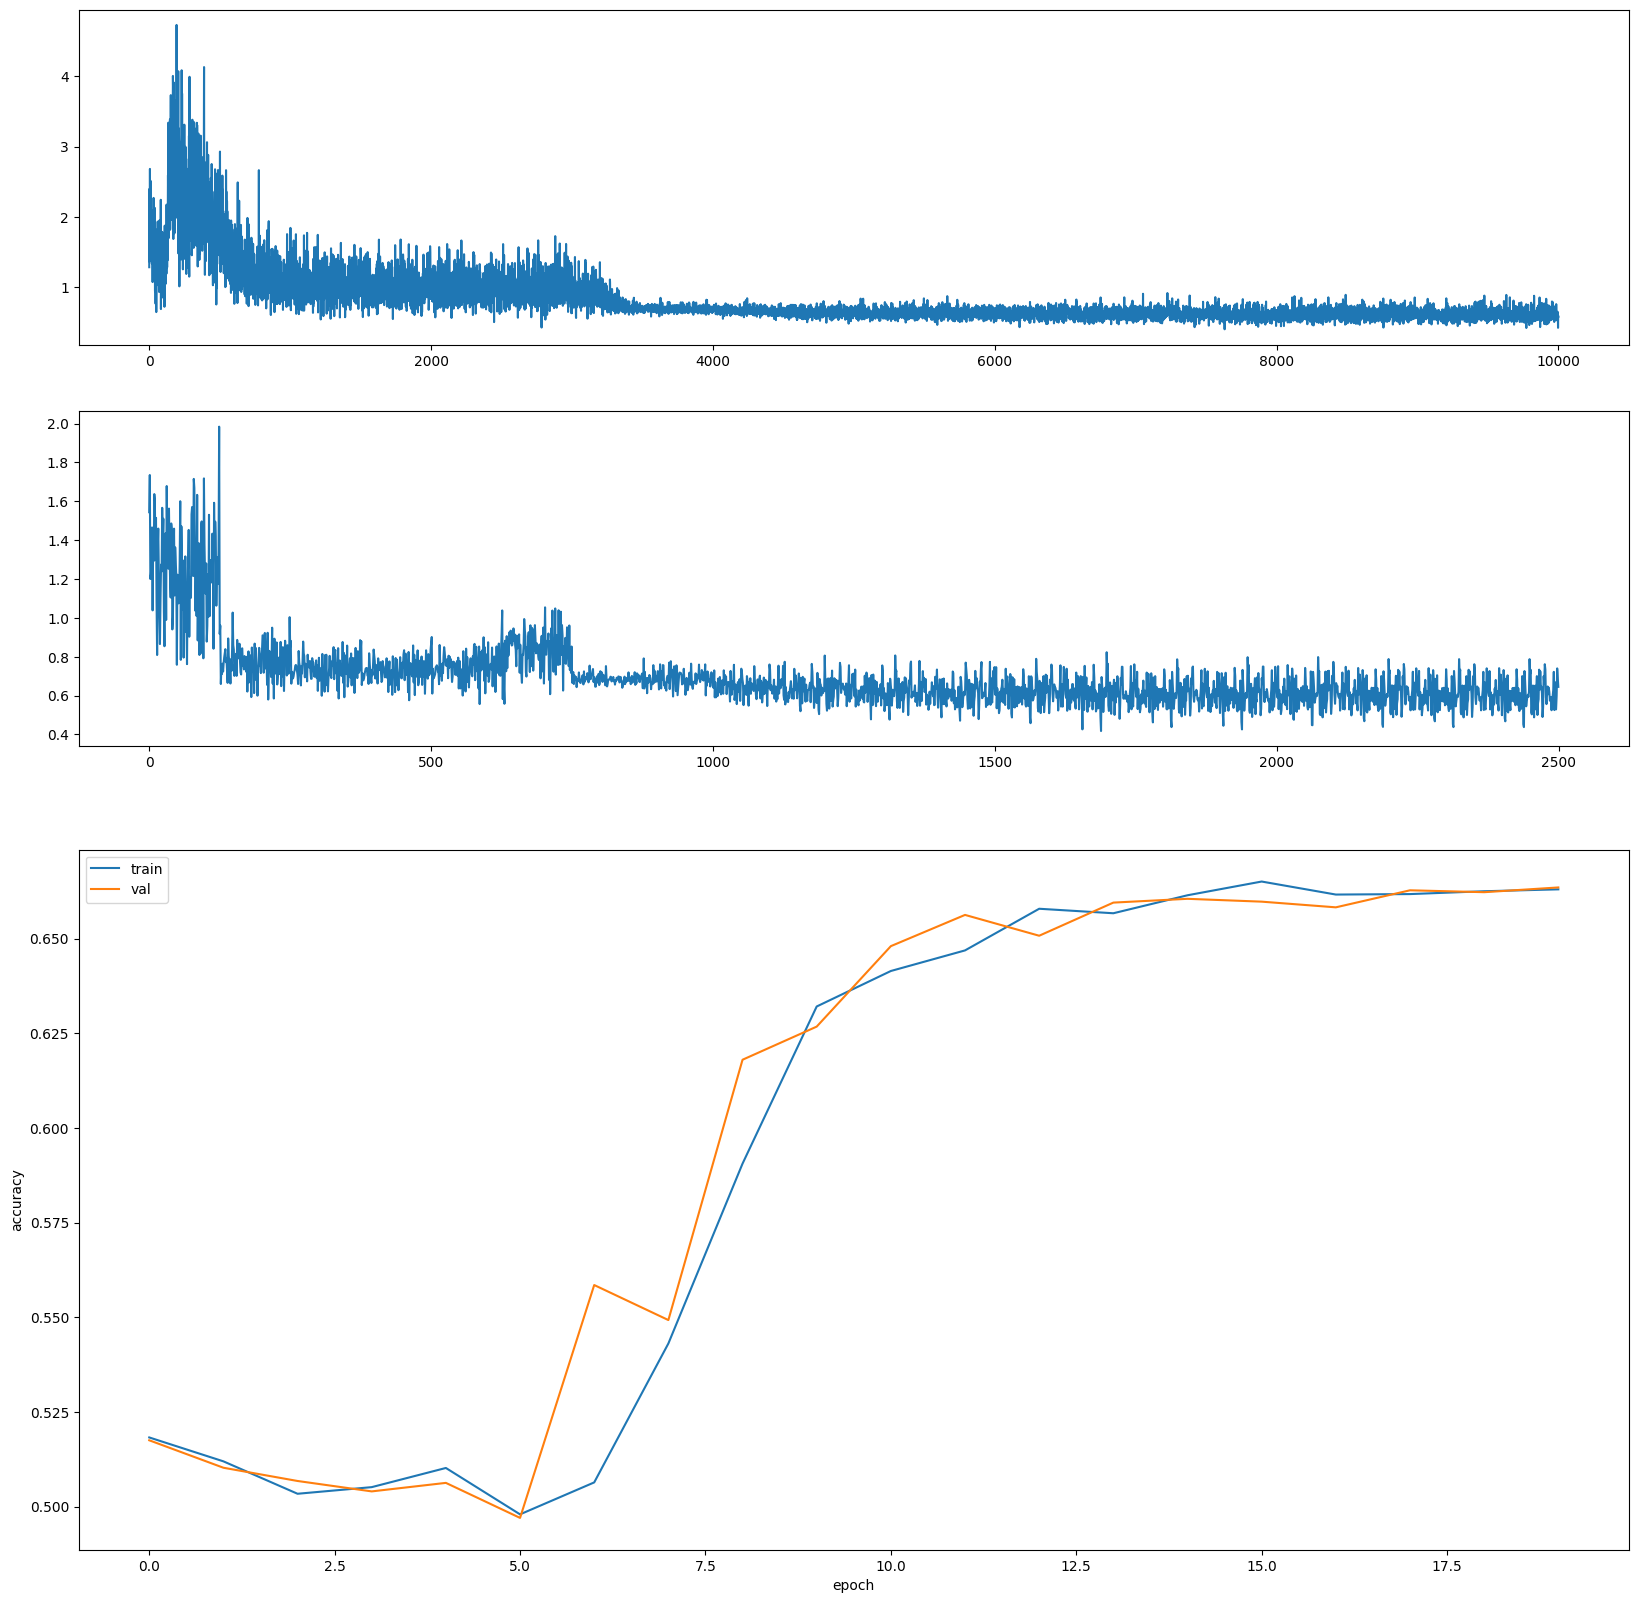

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

fig = plt.figure(figsize=(20,20))
a = fig.add_subplot(4, 1, 1)
b = fig.add_subplot(4, 1, 2)
c = fig.add_subplot(2, 1, 2)
a.plot(all_loss['train_loss'])
b.plot(all_loss['val_loss'])
c.plot(all_acc['train_acc'])
c.plot(all_acc['val_acc'])
c.set(xlabel='epoch', ylabel='accuracy')
c.legend(['train', 'val'])

pass

In [ ]:
# to complete

# _, y_pred, _ = validation(test_dataloader, device)

# submit = pd.read_csv('/kaggle/input/nlp-getting-started/sample_submission.csv')
# submit['target'] = y_pred

# submit.to_csv('submission.csv', index=False)